# Assignment 3

You have been provided a corpus of news articles. Your task is to identify prevalent topics by applying both LDA and BERTopic. To complete this assignment:

- Explain how you chose the number of topics for each approach, as well as any other pertinent hyperparameters. Include any relevant visualizations you used for selecting the number of topics.
- Interpret model results by assigning a label to each topic that represents what the topic is about (i.e. "Technology in healthcare", or "Computer Software"). You must provide some kind of evidence that (topic model outputs, random samples of data, etc) that your labels are sensible.
- Discuss the differences in the output between the two approaches.

## Preprocessing 

In [1]:
import pandas as pd
import multiprocessing as mp

import spacy
import pyLDAvis
import matplotlib.pyplot as plt
import pyLDAvis.gensim_models as gensimvis
from gensim.models import Phrases, LdaModel, LdaMulticore, CoherenceModel
from gensim.corpora import Dictionary

RANDOM_STATE = 0
CPU_COUNT = mp.cpu_count()
SPACY_MODEL = "en_core_web_md"

url = "https://storage.googleapis.com/adsp-nlp-open/data/nlp_a_6_news.json"
news_df = pd.read_json(url, orient="records", lines=True).sample(n=5000, random_state=RANDOM_STATE)

In [2]:
news_df

,url,date,language,title,text
3844,https://www.kxii.com/prnewswire/2022/05/23/com...,2022-05-23,en,COMPUTEX 2022 Global Press Conference Industry...,COMPUTEX 2022 Global Press Conference Industry...
3617,https://www.bigrapidsnews.com/business/article...,2022-06-09,en,"Moderna, Roku rise; Scotts Miracle-Gro, Charle...","Moderna, Roku rise; Scotts Miracle-Gro, Charle..."
2608,https://www.devdiscourse.com/article/education...,2022-04-12,en,Create entrepreneurship ecosystem in districts...,Create entrepreneurship ecosystem in districts...
3857,https://www.seattletimes.com/seattle-news/heal...,2022-04-30,en,Connecticut Senate OKs bill that protects abor...,Connecticut Senate OKs bill that protects abor...
1595,https://www.breakinglatest.news/news/maturity-...,2022-07-24,en,"Maturity, thanks from Fabio and Adriana: “Incl...","Maturity, thanks from Fabio and Adriana: “Incl..."
...,...,...,...,...,...
4397,https://www.benzinga.com/quote/ODP,2022-02-24,en,"ODP (NASDAQ:ODP) Stock Price, News, Charts - B...","ODP (NASDAQ:ODP) Stock Price, News, Charts - B..."
8697,https://gadgets360.com/mobiles/news/motorola-m...,2022-02-17,en,"Moto G22 Price, Specifications Leak; MediaTek ...","Moto G22 Price, Specifications Leak; M..."
5873,https://www.seattletimes.com/sports/boston-lea...,2022-01-28,en,Boston leads No. 1 South Carolina to 69-40 win...,Boston leads No. 1 South Carolina to 69-40 win...
6123,https://www.thenationalnews.com/business/marke...,2022-07-20,en,"Netflix loses 970,000 subscribers but quarterl...","Netflix loses 970,000 subscribers but quarterl..."


In [3]:
def clean_text(corpus, spacy_pipeline, as_string=True, n_proc=2, batch_size=1000):
    """
    Cleans a sequence of text by applying some simple processing techniques.

    Args:
        corpus (Iterable): a sequence of text to be processed
        spacy_pipeline: the Spacy pipeline object for processing text
        n_proc (int): the number of processors to use for parallel processing
        batch_size (int): the number of texts to process in a single batch

    Returns:
        clean_sequence (list): a cleaned version of the original text
    """
    # container to store cleaned documents
    corpus_clean = []

    for doc in spacy_pipeline.pipe(
        corpus,
        disable=["ner"],
        n_process=n_proc,
        batch_size=batch_size
    ):

        # container for cleaned document tokens
        doc_tokens = [
            token.lemma_.lower()
            for token in doc
            if not token.is_stop and token.is_alpha and (len(token) > 1) and token.pos_ in ("NOUN", "VERB") # should consider if these are appropriate
        ]
        
        if as_string:
            corpus_clean.append(" ".join(doc_tokens))
        else:
            corpus_clean.append(doc_tokens)

    return corpus_clean

In [4]:
# loading spacy model
nlp = spacy.load(SPACY_MODEL)

In [5]:
# apply cleaning to dataC
normalized_corpus = clean_text(
    corpus=news_df["text"].tolist(),
    spacy_pipeline=nlp,
    as_string=False
)

raw_corpus=news_df["text"].tolist()

In [25]:
raw_title=news_df["title"].tolist()

In [6]:
# training the phrases to find bigrams
bigram_phraser = Phrases(normalized_corpus) # this might require some eda, to decide min_count

# adding bigrams to the original unigram data
for idx in range(len(normalized_corpus)):
    for phrase in bigram_phraser[normalized_corpus[idx]]:
        if '_' in phrase:
            # phrase is a bigram, add to document.
            normalized_corpus[idx].append(phrase)

## LDA

### Creating Vocabulary

In [7]:
# a dictiohary is the mapping of an id to a word
dictionary = Dictionary(normalized_corpus)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=0.01*len(normalized_corpus), no_above=0.5)

In [8]:
corpus = [dictionary.doc2bow(doc) for doc in normalized_corpus]

print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 4226
Number of documents: 5000


### Training

In [9]:
min_topics = 2
max_topics = 20
step_size = 1
topics_range = range(min_topics, max_topics + 1, step_size)
# num_topics = 5 # the number of topics we want the model to return
chunksize = 100 # number of documents to be used in each training chunk
passes = 20 # epochs
iterations = 400 # how many times the model iterates over each document during a single pass / epoch
eval_every = 0  # affects speed and quality of the model, can increase for larger datasets

coherence_scores = []

for num_topics in topics_range:
    model = LdaMulticore(
        corpus=corpus,
        id2word=dictionary,
        chunksize=chunksize,
        alpha='symmetric',
        eta='auto',
        iterations=iterations,
        num_topics=num_topics,
        passes=passes,
        eval_every=eval_every,
        workers=3,
        random_state=RANDOM_STATE
    )
    
    # Compute Coherence Score
    coherence_model = CoherenceModel(model=model, texts=normalized_corpus, dictionary=dictionary, coherence='c_v') 
    ## Coherence parameter determines what scope and measure we are going to evaluate the coherence scores. 
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append(coherence_score)

The LDA hyperparameters were selected to balance model stability, interpretability, and computational efficiency. The number of topics was explored across a range of 2 to 20 to avoid both underfitting and over-fragmentation of topics. A chunk size of 100 documents was used to support efficient learning while maintaining stable parameter updates. The model was trained for 20 passes with 400 iterations per document to ensure adequate convergence of topic distributions. Intermediate evaluations were disabled to improve performance during the topic number sweep, with model selection performed after using coherence metrics.

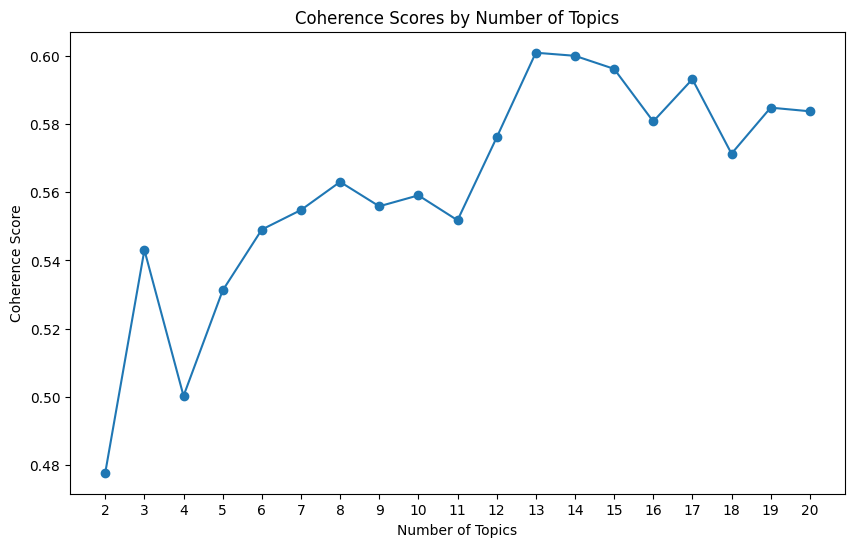

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(topics_range, coherence_scores, marker='o')
plt.title("Coherence Scores by Number of Topics")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.xticks(topics_range)
plt.show()

From the coherent score, we observe there is a significant jump between 5 and 6 and plateau around 9 and 12 until it peaks at 13. I think it's sensible to look through those texts and make the final judgement.  

In [11]:
num_topics = 9 # the number of topics we want the model to return

model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    chunksize=chunksize,
    alpha="auto",
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every,
    random_state=RANDOM_STATE
)

# model.show_topics(num_words=20)

[(0,
  '0.051*"user" + 0.045*"website" + 0.043*"set" + 0.024*"ad" + 0.024*"cooky" + 0.021*"datum" + 0.021*"store" + 0.020*"information" + 0.020*"product" + 0.020*"target" + 0.017*"visit" + 0.015*"visitor" + 0.014*"collect" + 0.013*"page" + 0.013*"site" + 0.012*"use" + 0.011*"help" + 0.011*"track" + 0.011*"icon" + 0.010*"care"'),
 (1,
  '0.014*"star" + 0.011*"reveal" + 0.010*"look" + 0.008*"show" + 0.008*"share" + 0.007*"dress" + 0.007*"husband" + 0.006*"child" + 0.006*"deal" + 0.006*"daughter" + 0.006*"wife" + 0.006*"post" + 0.005*"find" + 0.005*"film" + 0.005*"love" + 0.005*"figure" + 0.005*"leave" + 0.005*"son" + 0.005*"go" + 0.005*"fan"'),
 (2,
  '0.082*"open" + 0.054*"link" + 0.053*"tab" + 0.025*"link_open" + 0.024*"open_tab" + 0.021*"join" + 0.017*"people" + 0.016*"window" + 0.015*"tab_link" + 0.014*"date" + 0.012*"subscription" + 0.011*"manage" + 0.011*"dialog" + 0.011*"read" + 0.010*"go" + 0.010*"email" + 0.009*"way" + 0.009*"message" + 0.009*"mom" + 0.009*"send"'),
 (3,
  '0.07

In [12]:
for i in range(num_topics):
    print(f"\nTopic {i}:")
    print([w for w, _ in model.show_topic(i, topn=15)])


Topic 0:
['user', 'website', 'set', 'ad', 'cooky', 'datum', 'store', 'information', 'product', 'target', 'visit', 'visitor', 'collect', 'page', 'site']

Topic 1:
['star', 'reveal', 'look', 'show', 'share', 'dress', 'husband', 'child', 'deal', 'daughter', 'wife', 'post', 'find', 'film', 'love']

Topic 2:
['open', 'link', 'tab', 'link_open', 'open_tab', 'join', 'people', 'window', 'tab_link', 'date', 'subscription', 'manage', 'dialog', 'read', 'go']

Topic 3:
['share', 'stock', 'quarter', 'price', 'buy', 'earning', 'rating', 'analyst', 'sell', 'report', 'investor', 'value', 'trade', 'research', 'own']

Topic 4:
['cookie', 'rate', 'price', 'inflation', 'rise', 'market', 'fall', 'see', 'point', 'sell', 'month', 'plan', 'term', 'investor', 'oil']

Topic 5:
['video', 'song', 'hour', 'official', 'music', 'history', 'channel', 'case', 'shoot', 'state', 'kill', 'logo', 'month', 'police', 'post']

Topic 6:
['use', 'need', 'way', 'build', 'know', 'email', 'change', 'write', 'app', 'support', 'ad

In [13]:
def get_dominant_topic(model, corpus):
    doc_topics = []
    for doc in corpus:
        topics = model.get_document_topics(doc)
        topics = sorted(topics, key=lambda x: x[1], reverse=True)
        doc_topics.append(topics[0])
    return doc_topics

dominant_topics = get_dominant_topic(model, corpus)

In [14]:
dominant_topics

[(7, np.float32(0.68345)),
 (5, np.float32(0.41521934)),
 (6, np.float32(0.38961548)),
 (5, np.float32(0.5080319)),
 (6, np.float32(0.3132164)),
 (6, np.float32(0.4659728)),
 (2, np.float32(0.72720575)),
 (1, np.float32(0.816697)),
 (5, np.float32(0.3306852)),
 (5, np.float32(0.6489117)),
 (8, np.float32(0.67396545)),
 (6, np.float32(0.45039105)),
 (6, np.float32(0.3753512)),
 (5, np.float32(0.5311062)),
 (7, np.float32(0.5878013)),
 (7, np.float32(0.40331474)),
 (6, np.float32(0.29324856)),
 (5, np.float32(0.5013454)),
 (8, np.float32(0.51499146)),
 (6, np.float32(0.282061)),
 (8, np.float32(0.36896497)),
 (7, np.float32(0.6130401)),
 (4, np.float32(0.76106143)),
 (3, np.float32(0.9733549)),
 (2, np.float32(0.7941177)),
 (4, np.float32(0.77224714)),
 (6, np.float32(0.44208053)),
 (2, np.float32(0.6004697)),
 (2, np.float32(0.8450336)),
 (7, np.float32(0.6025299)),
 (6, np.float32(0.4427596)),
 (6, np.float32(0.40483359)),
 (4, np.float32(0.42242128)),
 (4, np.float32(0.68387157)),
 (7

In [27]:
import random
import textwrap
from collections import defaultdict

random.seed(RANDOM_STATE)

def wrap(text, width=90):
    return "\n".join(textwrap.wrap(text, width=width))

# build topic -> list of (doc_id, topic_prob)
topic_docs = defaultdict(list)

for doc_id, doc in enumerate(corpus):
    topics = model.get_document_topics(doc, minimum_probability=0)
    top_topic, top_prob = max(topics, key=lambda x: x[1])
    topic_docs[top_topic].append((doc_id, top_prob))

for topic_id in range(num_topics):
    docs = topic_docs[topic_id]
    if not docs:
        continue

    print("\n" + "=" * 80)
    print(f"TOPIC {topic_id}  |  Documents: {len(docs)}")
    print("=" * 80)

    # ---- Top / Pure docs ----
    print("\n Top (highest-probability) examples:")
    top_docs = sorted(docs, key=lambda x: x[1], reverse=True)[:3]

    for i, (doc_id, prob) in enumerate(top_docs, 1):
        print(f"\n  [{i}] p = {prob:.3f}")
        print("  RAW:")
        print(wrap(raw_title[doc_id]))
        # print("  TOKENS:")
        # print("  " + ", ".join(normalized_corpus[doc_id][:30]) + (" ..." if len(normalized_corpus[doc_id]) > 30 else ""))

    # ---- Random docs ----
    print("\n Random examples:")
    k = min(3, len(docs))
    rand_docs = random.sample(docs, k=k)

    for i, (doc_id, prob) in enumerate(rand_docs, 1):
        print(f"\n  [{i}] p = {prob:.3f}")
        print("  RAW:")
        print(wrap(raw_title[doc_id]))
        # print("  TOKENS:")
        # print("  " + ", ".join(normalized_corpus[doc_id][:30]) + (" ..." if len(normalized_corpus[doc_id]) > 30 else ""))


TOPIC 0  |  Documents: 276

 Top (highest-probability) examples:

  [1] p = 0.683
  RAW:
Xpeng Loss Widens as Supply-Chain Issues Hit Chinese EV Maker - BNN Bloomberg

  [2] p = 0.675
  RAW:
Have you spent $100 to fill your gas tank? We want to hear from you - BNN Bloomberg

  [3] p = 0.650
  RAW:
‘This Is a Recession Trade’: Stocks, Yields, Oil All Decline - BNN Bloomberg

 Random examples:

  [1] p = 0.308
  RAW:
Unhappy With Your 401(k)? Make These Changes ASAP | Smart Change: Personal Finance |
lacrossetribune.com

  [2] p = 0.229
  RAW:
UiPath Shares Dive 25% on Weak Outlook - NewsBreak

  [3] p = 0.466
  RAW:
Stocks end lower on Wall Street after another volatile day

TOPIC 1  |  Documents: 166

 Top (highest-probability) examples:

  [1] p = 0.753
  RAW:
La casa de los famosos: Nacho Casano llora por la eliminación de Juan Vidal – Telemundo
Dallas (39)

  [2] p = 0.676
  RAW:
Shopkeeper who told 81-year-old his EuroMillions ticket was a loser is jailed for 28
months | Daily Mai

There seems to be a clear enough 

In [31]:
for i in range(num_topics):
    print(f"\nTopic {i}:")
    print([w for w, _ in model.show_topic(i, topn=15)])


Topic 0:
['video', 'official', 'history', 'win', 'shoot', 'kill', 'charge', 'woman', 'police', 'man', 'case', 'post', 'talk', 'live', 'hit']

Topic 1:
['song', 'star', 'reveal', 'look', 'show', 'child', 'share', 'love', 'dress', 'husband', 'post', 'wife', 'son', 'daughter', 'film']

Topic 2:
['market', 'business', 'provide', 'product', 'technology', 'datum', 'industry', 'growth', 'increase', 'platform', 'release', 'grow', 'solution', 'view', 'report']

Topic 3:
['hour', 'music', 'channel', 'week', 'school', 'city', 'car', 'state', 'people', 'weather', 'student', 'vehicle', 'home', 'crash', 'gun']

Topic 4:
['rise', 'market', 'expect', 'price', 'point', 'see', 'gaming', 'inflation', 'pay', 'plan', 'loss', 'cash', 'tax', 'fall', 'economy']

Topic 5:
['pm', 'set', 'website', 'information', 'visit', 'base', 'people', 'value', 'lead', 'read', 'minute', 'government', 'story', 'term', 'customer']

Topic 6:
['cookie', 'user', 'datum', 'menu', 'information', 'account', 'store', 'password', 'si

In [16]:
# Prepare the visualization
vis_data = gensimvis.prepare(model, corpus, dictionary)

# display
pyLDAvis.display(vis_data)

**Topic 0 — Market & Economic News**

Theme: Financial markets, macroeconomics, and business conditions.

Evidence:
	•	Stock market movements, recession language, oil prices
	•	Corporate performance (EV makers, earnings, outlooks)
	•	Personal finance articles occasionally appear (401k)

Interpretation:
This topic captures general financial and economic reporting, especially market volatility and macro trends.

Quality:
- Coherent
- Slight bleed into personal finance, but still interpretable

⸻

**Topic 1 — Tabloid / Sensational News**

Theme: Sensational, emotionally charged human-interest stories.

Evidence:
	•	Celebrity gossip, crime stories, scandal framing
	•	Strong Daily Mail / tabloid style signals
	•	Emphasis on shock, drama, or moral judgment

Interpretation:
This topic represents tabloid-style news and viral sensational content.

Quality:
- Very coherent
- Strong stylistic identity

⸻

**Topic 2 — Celebrity Entertainment (PEOPLE.com)**

Theme: Mainstream celebrity news and pop culture.

Evidence:
	•	Repeated PEOPLE.com articles
	•	Celebrity quotes, TV shows, public figures
	•	High topical purity and very high probabilities

Interpretation:
A clean, source-specific entertainment cluster centered on celebrity culture.

Quality:
- Extremely coherent
- One of the strongest topics in the model

⸻

**Topic 3 — Mixed Business / Policy Headlines**

Theme: Broad institutional news touching business, tech, and government.

Evidence:
	•	Nasdaq headlines
	•	Corporate updates, policy actions, tech regulation
	•	Public health and government actions mixed in

Interpretation:
This topic captures institutional or “wire-service” style reporting, often headline-driven rather than thematic.

Quality:
- Moderately coherent
- Some thematic diffusion

⸻

**Topic 4 — Technology, Computing & Industry**

Theme: Technology products, computing, and industry events.

Evidence:
	•	Hardware forums, tech conferences
	•	Gaming and software news
	•	Big tech comparisons (Microsoft vs Google)

Interpretation:
A broad technology and computing ecosystem topic.

Quality:
- Very large topic (overrepresented)
- Possibly too broad → could be split at higher K

⸻

**Topic 5 — U.S. Politics & Public Affairs**

Theme: Domestic U.S. political and governmental news.

Evidence:
	•	Abortion legislation
	•	Government officials and policy
	•	National and international political coverage

Interpretation:
This topic represents formal political and public policy reporting.

Quality:
- Coherent
- Some sports/business bleed in random samples

⸻

**Topic 6 — Stock Price Movements (Equities News)**

Theme: Daily stock price movements and market performance.

Evidence:
	•	Repeated “falls/gains X%” patterns
	•	ETF and individual stock updates
	•	Consistent source and phrasing

Interpretation:
A transactional market data topic focused on stock performance summaries.

Quality:
- Very coherent
- Narrow and well-defined

⸻

**Topic 7 — Investment Activity & Funds**

Theme: Investment decisions, funds, and institutional activity.

Evidence:
	•	“Buys” / “sells” reporting
	•	GuruFocus, Seeking Alpha
	•	Earnings and valuation discussions

Interpretation:
This topic captures investment strategy and institutional trading behavior.

Quality:
- Coherent
- Overlaps conceptually with Topics 0 and 6, but stylistically distinct

⸻

**Topic 8 — Sports, Gaming & Viral Media**

Theme: Mixed sports, gaming, and online video content.

Evidence:
	•	Sports highlights
	•	Game trailers
	•	YouTube/short-form viral content
	•	Some crime or breaking-news bleed

Interpretation:
A media-driven entertainment topic, skewed toward sports and digital video.

Quality:
- Mixed but interpretable
- Broad lifestyle/media bucket

In [32]:
num_topics = 13 # the number of topics we want the model to return

model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    chunksize=chunksize,
    alpha="auto",
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every,
    random_state=RANDOM_STATE
)

# model.show_topics(num_words=20)

In [33]:
random.seed(RANDOM_STATE)

def wrap(text, width=90):
    return "\n".join(textwrap.wrap(text, width=width))

# build topic -> list of (doc_id, topic_prob)
topic_docs = defaultdict(list)

for doc_id, doc in enumerate(corpus):
    topics = model.get_document_topics(doc, minimum_probability=0)
    top_topic, top_prob = max(topics, key=lambda x: x[1])
    topic_docs[top_topic].append((doc_id, top_prob))

for topic_id in range(num_topics):
    docs = topic_docs[topic_id]
    if not docs:
        continue

    print("\n" + "=" * 80)
    print(f"TOPIC {topic_id}  |  Documents: {len(docs)}")
    print("=" * 80)

    # ---- Top / Pure docs ----
    print("\n Top (highest-probability) examples:")
    top_docs = sorted(docs, key=lambda x: x[1], reverse=True)[:3]

    for i, (doc_id, prob) in enumerate(top_docs, 1):
        print(f"\n  [{i}] p = {prob:.3f}")
        print("  RAW:")
        print(wrap(raw_title[doc_id]))
        # print("  TOKENS:")
        # print("  " + ", ".join(normalized_corpus[doc_id][:30]) + (" ..." if len(normalized_corpus[doc_id]) > 30 else ""))

    # ---- Random docs ----
    print("\n Random examples:")
    k = min(3, len(docs))
    rand_docs = random.sample(docs, k=k)

    for i, (doc_id, prob) in enumerate(rand_docs, 1):
        print(f"\n  [{i}] p = {prob:.3f}")
        print("  RAW:")
        print(wrap(raw_title[doc_id]))
        # print("  TOKENS:")
        # print("  " + ", ".join(normalized_corpus[doc_id][:30]) + (" ..." if len(normalized_corpus[doc_id]) > 30 else ""))


TOPIC 0  |  Documents: 121

 Top (highest-probability) examples:

  [1] p = 0.556
  RAW:
Un muerto, tres heridos en un tiroteo en Washington DC – Telemundo Washington DC (44)

  [2] p = 0.365
  RAW:
SecureKloud führt die CloudEdge-Plattform ein, um die Einführung der Cloud zu erleichtern

  [3] p = 0.362
  RAW:
Dog stolen from California shelter dies after being found on freeway – Queen City News

 Random examples:

  [1] p = 0.199
  RAW:
Billionaire LA candidate Caruso discloses vast  holdings | mypanhandle.com

  [2] p = 0.279
  RAW:
Steph Mic'd Up at ASG 🗣️ #Shorts | Oakland News Now Blog - Oakland East Bay News, SF Bay
Area, California, World

  [3] p = 0.161
  RAW:
3 flips for Hirano but a 4th win for James at Winter X | Federal News Network

TOPIC 1  |  Documents: 181

 Top (highest-probability) examples:

  [1] p = 0.580
  RAW:
Have you spent $100 to fill your gas tank? We want to hear from you - BNN Bloomberg

  [2] p = 0.572
  RAW:
Oil pares weekly loss with recession fears h

In [34]:
# Prepare the visualization
vis_data = gensimvis.prepare(model, corpus, dictionary)

# display
pyLDAvis.display(vis_data)



**Topic 0**
	- Crime (Telemundo)
	- Tech launch (German cloud platform)
	- Dog stolen story
	- Sports shorts
	- Crypto shorts

This is a semantic garbage bin.
No shared theme, no shared style, no shared source.

This topic exists only because the model ran out of structure and had to put leftovers somewhere.

⸻

**Topic 4**

Top examples mix:
	- Russia sanctions list
	- Retro gaming forum
	- Bella Hadid celebrity news

Random examples mix:
	- Central bank digital currency
	- Motorola phones
	- College basketball

This is pure fragmentation noise.

⸻

**Topic 8**
	- Python OOP courses
	- Government education policy
	- WhatsApp spam tutorials
	- TikTok instructions

This is an instructional / how-to sludge bucket, not a real topic.

⸻

Redundant / unnecessary splits

**Topic 11 vs Topic 9**

Both are celebrity news.
	- Topic 11 = PEOPLE.com (very clean)
	- Topic 9 = Telemundo + Daily Mail celebrity gossip

⸻

**Topic 10 vs Topic 2 vs Topic 8**

We now have:
	- Tech industry / infrastructure (Topic 2)
	- Consumer tech & gaming sales (Topic 10)
	- Random instructional tech (Topic 8)

### LDA Conclusion

Topic modeling was performed using Latent Dirichlet Allocation (LDA), with the number of topics selected through a combination of quantitative and qualitative evaluation. Quantitatively, models were compared across a range of topic counts using the c_v coherence score, which suggested modest improvements in coherence as the number of topics increased. However, coherence alone proved insufficient for determining the optimal model complexity.

To complement the quantitative analysis, qualitative topic validation was conducted through systematic human interpretation of representative documents within each topic. This qualitative assessment revealed that models with larger numbers of topics produced several semantically incoherent “residual” topics that mixed unrelated domains (e.g., crime, technology, sports, and instructional content), as well as redundant topic splits driven primarily by source or stylistic differences rather than substantive thematic distinctions.

In particular, higher-topic models exhibited fragmentation of otherwise coherent themes into artificial subtopics and the emergence of heterogeneous catch-all topics, indicating over-segmentation. Based on the combined evidence from coherence metrics and human-in-the-loop semantic inspection, a lower topic count was selected as the optimal balance between interpretability and thematic resolution.

## BERTopic

In [132]:
import pandas as pd

from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from sklearn.datasets import fetch_20newsgroups
from sklearn.cluster import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer

from umap import UMAP
from sentence_transformers import SentenceTransformer

In [133]:
# instantiating the embedding model
embedding_model = SentenceTransformer("thenlper/gte-small")

#### Attempt 1

In [160]:
# Step 2 - Reduce dimensionality
umap_model = UMAP(n_components=20, min_dist=0.0, metric='cosine', random_state=RANDOM_STATE)

# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom')

# Step 4 - Tokenize topics
vectorizer_model = CountVectorizer(stop_words="english", ngram_range=(1, 2))

# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer()

# All steps together
topic_model = BERTopic(
  embedding_model=embedding_model,          # Step 1 - Extract embeddings
  umap_model=umap_model,                    # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,              # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,        # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,                # Step 5 - Extract topic words
)

topics, probs = topic_model.fit_transform(news_df["text"])

In [161]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1464,-1_2022_new_media_said,"[2022, new, media, said, com, news, resize, jp...",[Cost of living crisis: Families cut back on f...
1,0,349,0_pm_2022_games_game,"[pm, 2022, games, game, xbox, new, gaming, pc,...",[Freedom Mobile user manages to get 30GB/$50 d...
2,1,317,1_seattle_times_seattle times_said,"[seattle, times, seattle times, said, streamin...",[California man suspected of killing girlfrien...
3,2,218,2_cloud_data_prnewswire_business,"[cloud, data, prnewswire, business, microsoft,...",[ Matillion Appoints General Counsel and Chief...
4,3,184,3_equities_equities com_password_nasdaq,"[equities, equities com, password, nasdaq, equ...",[Codexis (CDXS) falls 2.01% for January 26 | E...
...,...,...,...,...,...
56,55,17,55_investorsobserver_lp_options_lp symbol,"[investorsobserver, lp, options, lp symbol, ww...",[Thinking about trading options or stock in Ap...
57,56,17,56_link opens_link_new tab_tab,"[link opens, link, new tab, tab, opens new, op...","[ Star Tracks - Tuesday, November 4, 2008 | ..."
58,57,16,57_msfs_flight_ninja_flightsim,"[msfs, flight, ninja, flightsim, jessicablevin...","[FlightSim.Com - MSFS 2020 April 14th, 2022 De..."
59,58,15,58_explorer_internet explorer_internet_windows,"[explorer, internet explorer, internet, window...",[Reuters Odd News Summary | Daily Mail Online ...


In [162]:
topic_model.visualize_topics()

In [163]:
topic_model.visualize_hierarchy()

In [164]:
topic_model.visualize_barchart()

#### Attempt 2

In [165]:
# Step 2 - Reduce dimensionality
umap_model = UMAP(n_components=20, min_dist=0.0, metric='cosine', random_state=RANDOM_STATE)

# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(min_cluster_size=25, metric='euclidean', cluster_selection_method='eom')

# Step 4 - Tokenize topics
vectorizer_model = CountVectorizer(stop_words="english", ngram_range=(1, 2))

# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer()

# All steps together
topic_model = BERTopic(
  embedding_model=embedding_model,          # Step 1 - Extract embeddings
  umap_model=umap_model,                    # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,              # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,        # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,                # Step 5 - Extract topic words
)

topics, probs = topic_model.fit_transform(news_df["text"])

In [166]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1322,-1_new_2022_news_said,"[new, 2022, news, said, nbcdfw com, nbcdfw, co...",[Kim Kardashian called ex Kanye West in tears ...
1,0,521,0_shares_stock_nasdaq_company,"[shares, stock, nasdaq, company, equities, nys...",[Apple Inc. (NASDAQ:AAPL) Shares Sold by 180 W...
2,1,346,1_pm_2022_games_game,"[pm, 2022, games, game, xbox, new, gaming, pc,...",[Blizzard's Warcraft mobile game is probably n...
3,2,327,2_seattle_times_seattle times_said,"[seattle, times, seattle times, said, streamin...","[Boy, 6, killed in drive-by shooting at park; ..."
4,3,290,3_markets_stocks_inflation_market,"[markets, stocks, inflation, market, fed, stoc...","[ ECB to Discuss Rate Hike in June, Probably..."
5,4,252,4_cloud_data_prnewswire_business,"[cloud, data, prnewswire, business, technology...",[ Ateliere Wins Globee® in the 2nd Annual 2022...
6,5,177,5_people_link opens_link_opens,"[people, link opens, link, opens, new tab, tab...",[ Royal Baby 2015: Betting Odds on Name and ...
7,6,145,6_india_news_2022_delhi,"[india, news, 2022, delhi, indian, live, rs, c...",[Covid-19: Delhi likely to scale down reserved...
8,7,103,7_star_reveals_new_kardashian,"[star, reveals, new, kardashian, dress, husban...",[Kendall Jenner flaunts her toned midriff and ...
9,8,103,8_ukraine_russian_russia_said,"[ukraine, russian, russia, said, ukrainian, wa...",[What's going on in Russia? (ongoing thread) |...


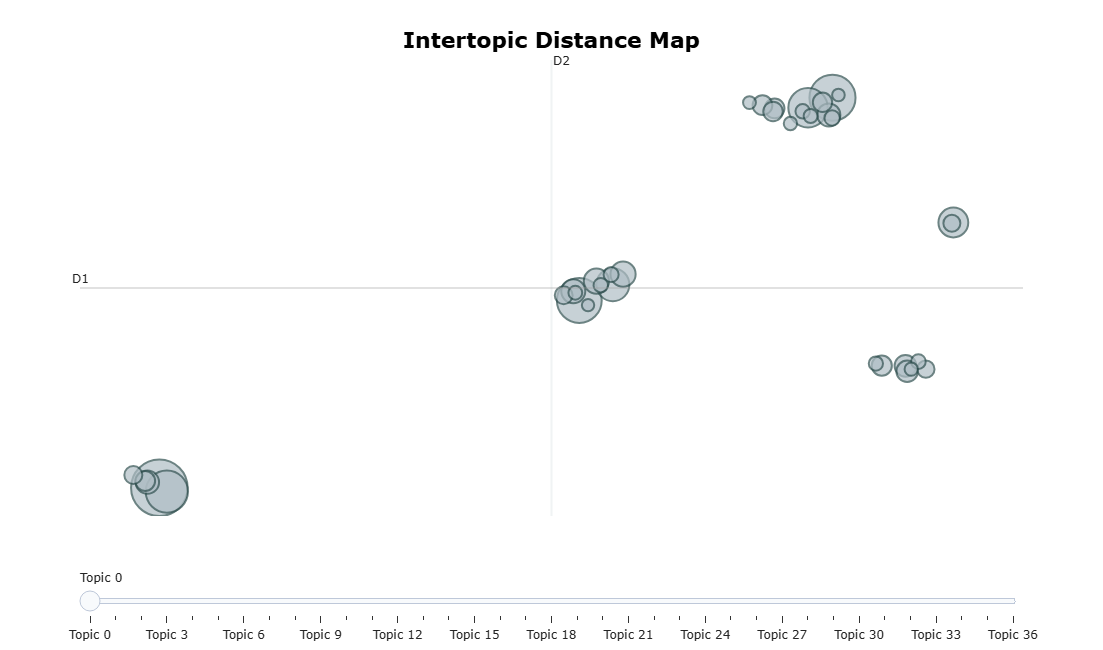

In [167]:
topic_model.visualize_topics()

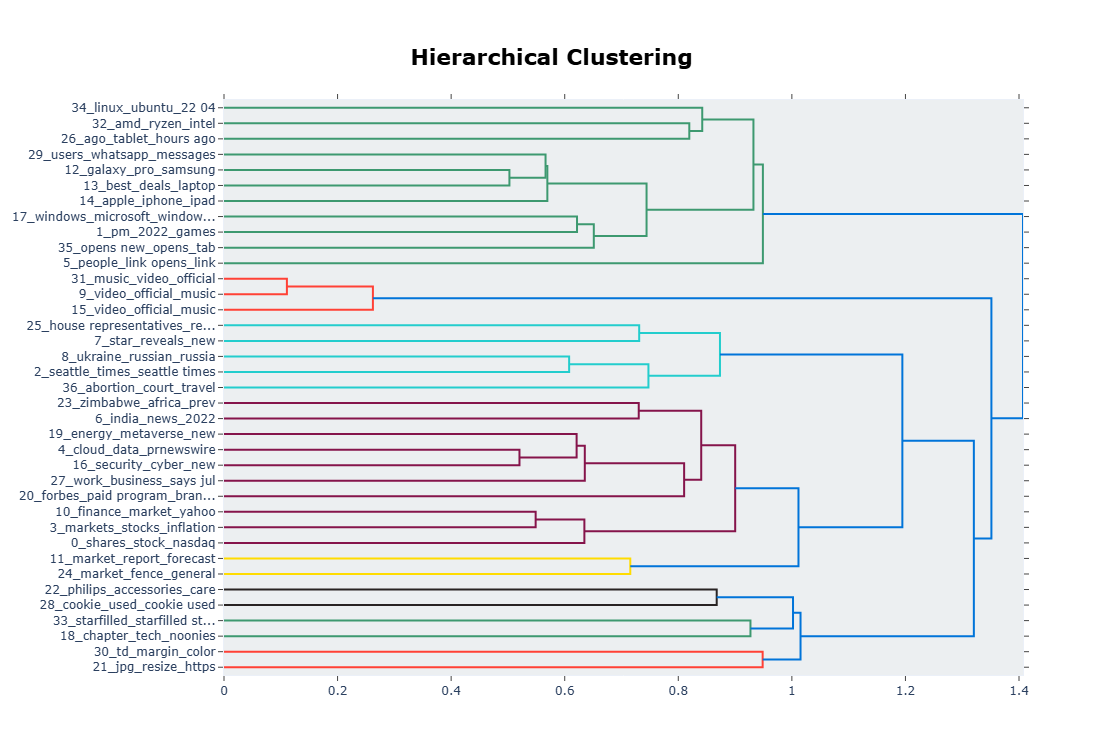

In [168]:
topic_model.visualize_hierarchy()

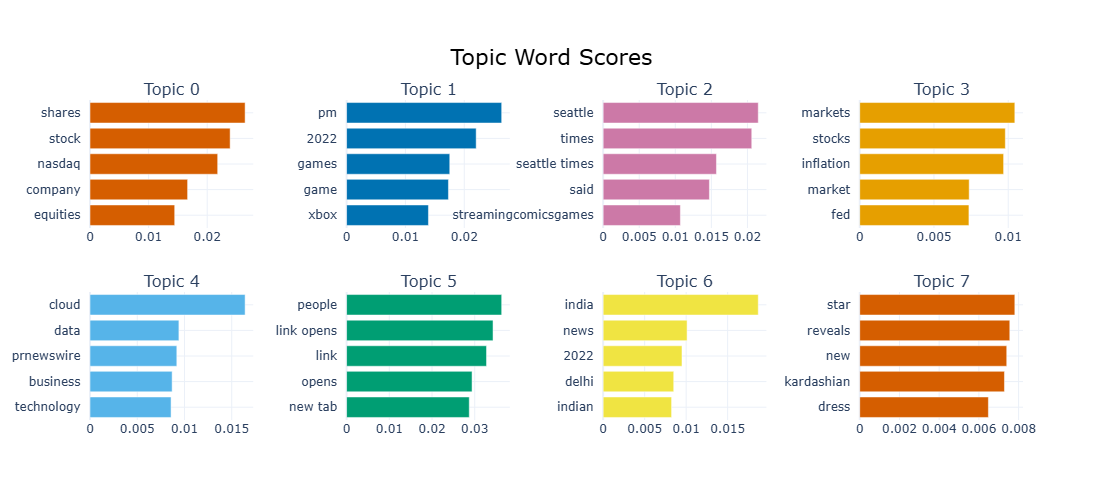

In [169]:
topic_model.visualize_barchart()

#### Attempt 3

In [170]:
# Step 2 - Reduce dimensionality
umap_model = UMAP(n_components=20, min_dist=0.0, metric='cosine', random_state=RANDOM_STATE)

# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(min_cluster_size=35, metric='euclidean', cluster_selection_method='eom')

# Step 4 - Tokenize topics
vectorizer_model = CountVectorizer(stop_words="english", ngram_range=(1, 3))

# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer()

# All steps together
topic_model = BERTopic(
  embedding_model=embedding_model,          # Step 1 - Extract embeddings
  umap_model=umap_model,                    # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,              # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,        # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,                # Step 5 - Extract topic words
)

topics, probs = topic_model.fit_transform(news_df["text"])

In [171]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1677,-1_new_2022_video_news,"[new, 2022, video, news, music, official, musi...",[Chapo Trap House - Roe v. Wade Movie Review |...
1,0,516,0_shares_stock_nasdaq_company,"[shares, stock, nasdaq, company, equities, nys...",[Apple Inc. (NASDAQ:AAPL) Shares Acquired by V...
2,1,342,1_pm_2022_game_games,"[pm, 2022, game, games, xbox, new, gaming, pc,...",[Blizzard's Warcraft mobile game is probably n...
3,2,314,2_times_seattle_said_seattle times,"[times, seattle, said, seattle times, advertis...",[President Biden to speak at Naval Academy gra...
4,3,294,3_markets_stocks_inflation_market,"[markets, stocks, inflation, market, fed, stoc...",[ Goldman Launches $900 Million Junk Bond fo...
5,4,275,4_cloud_data_business_technology,"[cloud, data, business, technology, prnewswire...",[DocuSign Announces First Quarter Fiscal 2023 ...
6,5,178,5_people_link opens_link_link opens new,"[people, link opens, link, link opens new, ope...",[ Angelina's Favorite Maxi Dresses | PEOPLE....
7,6,164,6_india_news_2022_indian,"[india, news, 2022, indian, live, delhi, said,...",[UP Election 2022: What small businesses in In...
8,7,104,7_video_music_official_music video,"[video, music, official, music video, official...",[Cobb County DA weighs in on death of Ahmaud A...
9,8,97,8_security_new_users_data,"[security, new, users, data, google, best, cyb...",[Dropbox is a Total Mess - SlashdotSlashdotSto...


In [172]:
topic_model.visualize_topics()

In [173]:
topic_model.visualize_hierarchy()

In [174]:
topic_model.visualize_barchart()

In [188]:
# Assign subtopics to the macro topics.

news_df['BERT_labels']= [topic_model.topic_labels_[t] for t in topics]

In [190]:
# 1) subtopic -> macro label
topic_to_macro = {
    -1: "Noise / Web Artifacts",
    0:  "Financial Markets & Business",
    1:  "Gaming & Media",
    2:  "Politics & World News",
    3:  "Financial Markets & Business",
    4:  "Enterprise / Cloud / Security",
    5:  "Noise / Web Artifacts",
    6:  "Politics & World News",
    7:  "Gaming & Media",
    8:  "Enterprise / Cloud / Security",
    9:  "Politics & World News",
    10: "Financial Markets & Business",
    11: "Entertainment & Celebrity",
    12: "Financial Markets & Business",
    13: "Consumer Technology & Devices",
    14: "Noise / Web Artifacts",
    15: "Gaming & Media",
    16: "Energy / Emerging Tech",
    17: "Enterprise / Cloud / Security",
    18: "Enterprise / Cloud / Security",
    19: "Noise / Web Artifacts",
    20: "Consumer Technology & Devices",
    21: "Consumer Technology & Devices",
    22: "Consumer Technology & Devices",
    23: "Consumer Technology & Devices",
    24: "Financial Markets & Business",
}

# 2) assign macro label to each document using its topic id
news_df["macro_label"] = news_df["topic"].map(topic_to_macro).fillna("Unlabeled")

In [192]:
import random
import textwrap

RANDOM_STATE = 42
random.seed(RANDOM_STATE)

def wrap(text, width=100):
    return "\n".join(textwrap.wrap(str(text), width))

for macro, group in news_df.groupby("macro_label"):
    print("\n" + "=" * 100)
    print(f"MACRO LABEL: {macro} | Documents: {len(group)}")
    print("=" * 100)

    sample = group.sample(
        n=min(8, len(group)),
        random_state=RANDOM_STATE
    )

    for i, row in enumerate(sample.itertuples(), 1):
        print(f"\n[{i}] topic={row.topic}")
        print(wrap(row.title))


MACRO LABEL: Consumer Technology & Devices | Documents: 271

[1] topic=21
Visit the support page for your 7000 Series Straightener BHS732/00 | Philips

[2] topic=20
Microsoft’s faster Windows 11 Update speed claims just don’t add up | TechRadar

[3] topic=21
Visit the support page for your Philips 5000 Series Food processor HR7302/90

[4] topic=22
Developer Makes Use of the MacBook Pro Notch to AirDrop Files

[5] topic=23
Gateway's Baby Cow is Jumping Over the Moon for the New Lineup of Notebooks | News | wfmz.com

[6] topic=20
Google Docs Is Getting Smarter

[7] topic=22
Apple dives deeper into cars with software for car dashboard

[8] topic=20
Get Microsoft Office and Windows at the lowest prices during the Keysfan Easter Sale - Dot Esports

MACRO LABEL: Energy / Emerging Tech | Documents: 63

[1] topic=16
CRUISE’S DRIVERLESS AUTONOMOUS CARS START GIVING RIDES TO PAYING PASSENGER - Impact Lab

[2] topic=16
New Kia Niro, two-tone versions arrive-breakinglatest.news-Breaking Latest Ne

#### BERTopic Conclusion

We evaluated multiple values of the min_cluster_size hyperparameter (15, 25, and 35) using intertopic distance maps and hierarchical clustering visualizations. While min_cluster_size = 15 resulted in excessive fragmentation and noise-driven topics, and min_cluster_size = 25 produced several redundant subtopics, min_cluster_size = 35 preserved the same high-level semantic structure with fewer, more interpretable topics. The hierarchical clustering visualization showed that many topics at min_cluster_size = 25 merged at low distances, indicating that they were not meaningfully distinct. Therefore, min_cluster_size = 35 was selected as the final model configuration.

Some macro-topics include a small number of semantically related but editorially heterogeneous articles. This reflects BERTopic’s embedding-based clustering, which prioritizes semantic proximity over strict source or genre boundaries. We validated these groupings using hierarchical topic visualizations and stratified random sampling of article titles, confirming that the dominant semantic themes within each macro-topic remain coherent.

## Final Conclusion

Both LDA and BERTopic were applied to identify latent themes in the news corpus, with model selection guided by a combination of quantitative metrics, visual diagnostics, and qualitative inspection.

For LDA, topic count was informed by c_v coherence scores and manual review of representative documents. While coherence improved slightly with more topics, higher-topic models introduced fragmented and semantically incoherent residual topics, often mixing unrelated domains. A lower topic count was therefore selected to balance interpretability and thematic clarity.

For BERTopic, multiple values of the min_cluster_size hyperparameter (15, 25, and 35) were evaluated using intertopic distance maps, hierarchical clustering, and random sampling of article titles. Smaller values led to over-fragmentation, while intermediate values produced redundant subtopics that merged at low hierarchical distances. The configuration with min_cluster_size = 35 preserved the same high-level semantic structure with fewer, more interpretable topics and was selected as the final model.

Overall, LDA produced broader, less precise topics that required substantial human interpretation, whereas BERTopic yielded more semantically coherent clusters driven by contextual embeddings. Minor editorial heterogeneity within some BERTopic macro-topics reflects semantic proximity rather than modeling error and was validated through hierarchical analysis and random sample checks.